# Applied Machine Learning: Assignment 4, Eric Johansson & Max Sonnelid

## Implementing linear classifiers

In this assignment, you will implement two algorithms to train classifiers: support vector classification and logistic regression. The pedagogical objectives of this assignment are that we should (1) get some experience of the practical considerations of implementing machine learning algorithms, (2) understand SVC and LR more thoroughly, and (3) get a taste of how a typical academic paper in machine learning looks.

## Exercise question

*When we use this set, for some strange reason our classifier performs poorly! We can't improve it by switching to a LinearSVC. Do you have an idea what's going on? Why could the classifier "memorize" the training data in the first case, but not in the second case?*

Below the data from the assignment PM is presented in the shape of scatter plot in order to understand the data better.

Studying the graph for the first training data (Gothenburg + Paris), it is easy to see that a linear classifier could be able to draw a straight line for distinguishing the two groups (red dots for rain and blue dots for sun) based on the two available features. When making predictions from the trained classifier on the same data set, the linear classifier uses this line for classifying the data points as either rain and sun. As the line divides the target features without any misplacements, the linear classifier will reach a 100 % accuracy.

Instead looking at the graph for the second training data (Sydney + Paris), it is not possible to draw a straight line for distinguishing the two groups (rain resp. sun). Any attempt to draw such a line will lead to half of the data points being misplaced in the wrong groups. Both the perceptron and the linear SVC have attempted to draw such a straight line to the best of their abilities. When making predictions from these trained linear classifiers on the same data set, they both only reach an accuracy of 50 %, which is explained by the logical impossibility to create a 100 % accurate linear division of this data. For this data set, it should probably be suggested to use classifiers based on non-linear functions, for example neural networks, in order to reach an accuracy of 100 %.

## Scatter plots for first training data (Gothenburg + Paris)

Numerical encoding of features:

- Cities: Gothenburg = 1, Paris = 0
- Months: July = 1, December = 0
- Weather: rain = 1, sun = 0

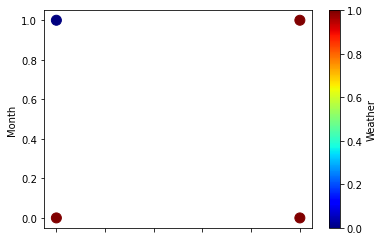

In [81]:
import pandas as pd

df = pd.DataFrame([[1, 1, 1], [1, 0, 1], [0, 1, 0], [0, 0, 1]],
                columns=['City', 'Month', 'Weather'])
df.plot.scatter(x='City', y='Month', c='Weather', colormap='jet', s=100)

## Scatter plots for second training set (Sydney and Paris)

Numerical encoding of features:

- Cities: Sydney = 1, Paris = 0

- Months: July = 1, December = 0

- Weather: rain = 1, sun = 0

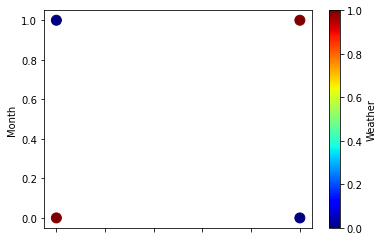

In [82]:
df2 = pd.DataFrame([[1, 1, 1], [1, 0, 0], [0, 1, 0], [0, 0, 1]],
                columns=['City', 'Month', 'Weather'])
df2.plot.scatter(x='City', y='Month', c='Weather', colormap='jet', s=100)

## SVC classifier class

In [2]:
import numpy as np
import random
import math
from sklearn.base import BaseEstimator
import scipy.linalg.blas as blas

## General class for binary linear classifiers (given code)

In [3]:
class LinearClassifier(BaseEstimator):
    """
    General class for binary linear classifiers. Implements the predict
    function, which is the same for all binary linear classifiers. There are
    also two utility functions.
    """

    def decision_function(self, X):
        """
        Computes the decision function for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """
        return X.dot(self.w)

    def predict(self, X):
        """
        Predicts the outputs for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """

        # First compute the output scores
        scores = self.decision_function(X)

        # Select the positive or negative class label, depending on whether
        # the score was positive or negative.
        out = np.select([scores >= 0.0, scores < 0.0],
                        [self.positive_class,
                         self.negative_class])
        return out

    def find_classes(self, Y):
        """
        Finds the set of output classes in the output part Y of the training set.
        If there are exactly two classes, one of them is associated to positive
        classifier scores, the other one to negative scores. If the number of
        classes is not 2, an error is raised.
        """
        classes = sorted(set(Y))
        if len(classes) != 2:
            raise Exception("this does not seem to be a 2-class problem")
        self.positive_class = classes[1]
        self.negative_class = classes[0]

    def encode_outputs(self, Y):
        """
        A helper function that converts all outputs to +1 or -1.
        """
        return np.array([1 if y == self.positive_class else -1 for y in Y])

## Given code from doc_classification for running the classifiers

In [37]:
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


# This function reads the corpus, returns a list of documents, and a list
# of their corresponding polarity labels.


def read_data(corpus_file):
    X = []
    Y = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            _, y, _, x = line.split(maxsplit=3)
            X.append(x.strip())
            Y.append(y)
    return X, Y


if __name__ == '__main__':

    # Read all the documents.
    X, Y = read_data('pa4/data/all_sentiment_shuffled.txt')

    # Split into training and test parts.
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2,
                                                    random_state=0)

    # Set up the preprocessing steps and the classifier.
    pipeline = make_pipeline(
        TfidfVectorizer(),
        #SelectKBest(k=1000),
        Normalizer(),

        # NB that this is our Perceptron, not sklearn.linear_model.Perceptron
        Pegasos_SVC()
    )

    # Train the classifier.
    t0 = time.time()
    pipeline.fit(Xtrain, Ytrain)
    t1 = time.time()
    print('Training time: {:.2f} sec.'.format(t1-t0))

    # Evaluate on the test set.
    Yguess = pipeline.predict(Xtest)
    print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))


Training time: 54.88 sec.
Accuracy: 0.8070.


## Pegasos_SVC

Below the Pegasos algorithm for training support vector classifiers is implemented as described in the clarification document. Several values for the regularization lamda were tried, e.g. 1.0 gave an accuracy score of around 0.75, but 0.001 gave an accuracy score above 0.8 and therefore 0.001 was chosen as the default value for the regularization lamda. In the example code about the Perceptron, 20 was set as the default value for the number of iterations. As 20 gave an accuracy above 0.8 also for Pegasos_SVC, this value was kept as the default value for the number of iterations. Probably the accuracy score can be improved even further by using methods such as GridSearchCV in order to more systematically iterate through different values for the regularization lamda and the number of iterations. However, this was not done in this assignment.

In [7]:
class Pegasos_SVC(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=20, lambda_reg=0.001):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lambda_reg = lambda_reg

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)

        # Pegasos algorithm:
        for i in range(0, self.n_iter):
            t = 1
            for x, y in zip(X, Ye):

                t = t + 1

                # Compute the learning rate
                eta = 1 / (self.lambda_reg*t)

                # Compute the output score for this instance.
                score = x.dot(self.w)

                # If there was an error, update the weights by the hinge loss algorithm
                if y*score < 1:
                    self.w = (
                        1 - eta*self.lambda_reg)*self.w + eta * y * x
                else:
                    self.w = (1 - eta*self.lambda_reg) * self.w

### Result with regular Pegasos algorithm.
           
Training time: 10.62 sec.

Accuracy: 0.8191.

Lambda: 0.001

### Without SelectKBest(k=1000)
Training time: 54.88 sec.

Accuracy: 0.8070.

Lambda: 0.001

## Logistic regression

Below the Logicstic Regression algorithm for classifiers is implemented as described in the clarification document. Similarly as with Pegasos_SVC, 0.001 was set as the regularization lambda and 20 as the number of iterations, which resulted in an accuracy score above 0.8.

Notably, Logistic Regression gives a slightly lower accuracy score compared to Pegasos_SVC (0.8082 vs 0.8191). The only difference between these two classifiers is that Pegasos_SVC uses hinge loss, while Logistic Regression uses log loss. The advantage with log loss is that its weight vector is constantly evolving by accumulating information from data, which leads to better estimates for probabilities at the cost of accuracy as misclassification is not punished in any distinct way. Hinge loss, on the other side, punishes misclassification clearly as the weight vector is only updated for the misclassified data points, which leads to a better accuracy at the cost of less accurate probabilities. This is shown in our case by the fact that Logistic Regression has a slightly lower accuracy than Pegasos_SVC.

Considering the training time, no noticeable difference was found when running both classifiers with feature limitation (SelectKBest(k=1000)). However, when removing this limitation, Pegasos_SVC was considerably faster compared to Logistic_Regression. The accuracy for both Pegasos_SVC and Linear_Regression decreased slightly when running them without the feature limitations.

In [10]:
class Logistic_Regression(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=20, lambda_reg=0.001):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lambda_reg = lambda_reg

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)

        # Logistic Regression algorithm:
        for i in range(1, self.n_iter+1):
            t=0
            for x, y in zip(X, Ye):
                t = t+1

                # Compute the learning rate
                eta = 1 / (self.lambda_reg*t)

                # Compute the output score for this instance.
                score = x.dot(self.w)

                # If there was an error, update the weights by the log loss algorithm.
                self.w = (1-eta*self.lambda_reg)*self.w + \
                    (y / (1+math.exp(y*score))) * eta * x

### Recorded result with Logistic Regression

Training time: 11.14 sec.

Accuracy: 0.8082.
        
Lambda: 0.001

### Without SelectKBest(k=1000)

Training time: 84.77 sec

Accuracy: 0.8019

Lambda: 0.001

# BONUS TASK 1: Making your code more efficient

## BONUS TASK 1A: Faster linear algebra operations

In this bonus task, it was attempted to speed up both of the algorithms by implementing the following functions from the scipy.linalg.blas library: ddot(x, y), dscal(a, x) &  daxpy(x, y, a=a). The aim with this is to improve the speed in the dot product and scalar product operations. When using normal normal NumPy linear algebra operations, a number of safety checks are carried out by NumPy, which can be avoided by the BLAS functions. Furthermore, BLAS methods often take advantage of CPU-specific operations depending on the current machine and is able to let kernels run in parallel for speeding up calculations. It was only in the fit method that calculations were found that could be speeded up and there the BLAS functions were implemented in all suitable operations.

Looking at the results for the Pegasos_SVC_faster, it was possible to reduce the running time with 25 % compared to Pegasos_SVC (from 10.62s to 7.94s). Looking at the result for the Logistic_Regression_faster, it was possible to reduce the running time with 16 % compared to Logistic_Regression (from 11.14s to 9.36s). For these rather short training times, the absolute reduction in training time is not rather impressive. However, imaging starting with a training time of 1 hour. Being able to reduce that training time with 20 % implies an absolute reduction of the training time by 12 minutes, which could be very helpful in a practical situation. These results were only produced by one single algorithm run and a more fair comparison of the training time could probably be done by running each algorithm several times and then compare the mean values from the iterations. This because the training time differs caused by random factors for each iteration. However, this was not done for this task because of time deficiency. Finally, no change in accuracy score was registered for both of the classifiers as expected, which means that it is possible to decrease the training time without compromising on accuracy.

## Pegasos_SVC_faster

In [12]:
class Pegasos_SVC_faster(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=20, lambda_reg=0.001):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lambda_reg = lambda_reg

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)

        # Pegasos algorithm (with added BLAS methods):
        for i in range(0, self.n_iter):
            t = 1
            for x, y in zip(X, Ye):

                t = t + 1

                # Compute the learning rate
                eta = 1 / (blas.dscal(self.lambda_reg, t))

                # Compute the output score for this instance.
                score = blas.ddot(x, self.w)

                # If there was an error, update the weights by the hinge loss algorithm
                if blas.dscal(y, score) < 1:
                    blas.daxpy(x, blas.dscal(
                        (1-blas.dscal(eta, self.lambda_reg)), self.w), a=blas.dscal(eta, y))
                else:
                    blas.dscal((1-blas.dscal(eta, self.lambda_reg)), self.w)


### Recorded result with the fast Pegasos algorithm.
           
Training time: 7.94 sec.

Accuracy: 0.8191.

Lambda: 0.001           

## Logistic_Regression_faster

In [16]:
class Logistic_Regression_faster(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=20, lambda_reg=0.001):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lambda_reg = lambda_reg

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)

        # Logistic Regression algorithm (with added BLAS methods):
        for i in range(0, self.n_iter):
            t = 1
            for x, y in zip(X, Ye):

                t = t+1

                # Compute the learning rate
                eta = 1 / (blas.dscal(self.lambda_reg, t))

                # Compute the output score for this instance.
                score = blas.ddot(x, self.w)

                # If there was an error, update the weights by the log loss method

                blas.daxpy(x, blas.dscal(
                    (1-blas.dscal(eta, self.lambda_reg)), self.w), a=(blas.dscal(eta, (y / (1+math.exp(blas.dscal(y, score)))))))

### Recorded result with fast Logistic Regression algorithm.

Training time: 9.36 sec.

Accuracy: 0.8082.

Lambda: 0.001

## BONUS TASK 1B: Using sparse vectors

In this bonus task, efficient methods for handling sparse vectors were implemented for both of the classifiers, which improve the use of memory and thus the speed when running the algorithm without the feature limitation (without SelectKBest(k=1000)). The SparsePerceptron code was used as example for the implementation, which resulted in implementing sparse_dense_dot() when calculating the score and add_sparse_to_dense() when calculating the weight vector.

A sparse vector is a vector with a large number of zeroes that take up unneccessary space, which can be expected to be the case for our data after removing the feature limitation. Therefore, sparse_dense_dot() and add_sparse_to_dense() work by only saving the indices and value for each weight connected to a feature, and thus save space by not needing to save zero values.

Looking at the result for the Sparse_Pegasos_SVC, it was possible to reduce the running time with 45 % compared to Pegasos_SVC (from 54.88s to 30.23s). Looking at the result for the Sparse_Logistic_Regression, it was possible to reduce the running time with 64 % compared to Logistic_Regression (from 84.77s to 30.91s). Compared to the improvements made in task 1A, the improvements made in this sub-task are bigger. Apparently, it was possible to save some memory during the calculations by not needing to store the zero values in the weight vector. However, as the data set in task 1A respectively in task 1B are not comparable because of the difference in number of features, these improvements can not be compared as equals.

## Help functions for task 1B


In [20]:
# The following part is for the optional task.

# Sparse and dense vectors don't collaborate very well in NumPy/SciPy.
# Here are two utility functions that help us carry out some vector
# operations that we'll need.


def add_sparse_to_dense(x, w, factor):
    """
    Adds a sparse vector x, scaled by some factor, to a dense vector.
    This can be seen as the equivalent of w += factor * x when x is a dense
    vector.
    """
    w[x.indices] += factor * x.data


def sparse_dense_dot(x, w):
    """
    Computes the dot product between a sparse vector x and a dense vector w.
    """
    return np.dot(w[x.indices], x.data)

## Sparse_Pegasos_SVC

In [21]:
class Sparse_Pegasos_SVC(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm,
    assuming that the input feature matrix X is sparse.
    """

    def __init__(self, n_iter=20, lambda_reg=0.001):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lambda_reg = lambda_reg

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.

        Note that this will only work if X is a sparse matrix, such as the
        output of a scikit-learn vectorizer.
        """
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        self.w = np.zeros(X.shape[1])

        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.
        XY = list(zip(X, Ye))

        for i in range(self.n_iter):
            t = 1
            for x, y in XY:

                t = t + 1

                # Compute the learning rate
                eta = 1 / (self.lambda_reg*t)

                # Compute the output score for this instance.
                # (This corresponds to score = x.dot(self.w) above.)
                score = sparse_dense_dot(x, self.w)

                self.w = (1 - eta*self.lambda_reg)*self.w

                # If there was an error, update the weights by the hinge loss algorithm.
                if y*score < 1:
                    # (This corresponds to self.w += y*x above.)
                    add_sparse_to_dense(x, self.w, (eta*y))

### Recorded results for Sparse_Pegasos_SVC

Training time: 30.23 sec

Accuracy: 0.8070

Lambda: 0.001

## Sparse_Logistic_Regression

In [23]:
class Sparse_Logistic_Regression(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm,
    assuming that the input feature matrix X is sparse.
    """

    def __init__(self, n_iter=20, lambda_reg=0.001):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lambda_reg = lambda_reg

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.

        Note that this will only work if X is a sparse matrix, such as the
        output of a scikit-learn vectorizer.
        """
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        self.w = np.zeros(X.shape[1])

        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.
        XY = list(zip(X, Ye))

        for i in range(self.n_iter):
            t = 1
            for x, y in XY:

                t = t + 1

                # Compute the learning rate
                eta = 1 / (self.lambda_reg*t)

                # Compute the output score for this instance.
                # (This corresponds to score = x.dot(self.w) above.)
                score = sparse_dense_dot(x, self.w)

                self.w = (1 - eta*self.lambda_reg)*self.w

                # Update weights by the log loss algorithm
                # (This corresponds to self.w += y*x above.)
                add_sparse_to_dense(
                    x, self.w, (eta*(y / (1+math.exp(y*score)))))

### Recorded results for Sparse_Logistic_Regression

Training time: 30.91 sec

Accuracy: 0.8019

Lambda: 0.001

## BONUS TASK 1C: Speeding up the scaling operation

For this bonus task, it was chosen to have Sparse_Pegasos_SVC and Sparse_Logistic_Regression as starting points for the new changes implemented. In the previous methods, the weight vector has been scaled for every single iteration. However, this is in fact not necessary as it is possible to only update the scaling factor in every iteration and then multiply the scaling factor with the weight vector only after all iterations have run. Such a change simplifies the calculations made and will thus result in a shorter training time.

Looking at the result for the Sparse_Pegasos_SVC_faster, it was possible to reduce the running time with 36 % compared to Sparse_Pegasos_SVC (from 30.23s to 19.28s). Looking at the result for the Sparse_Logistic_Regression_faster, it was possible to reduce the running time with 40 % compared to Sparse_Logistic_Regression (from 30.91s to 18.22s).

## Sparse_Pegasos_SVC_faster

In [25]:
class Sparse_Pegasos_SVC_faster(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm,
    assuming that the input feature matrix X is sparse.
    """

    def __init__(self, n_iter=20, lambda_reg=0.001):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lambda_reg = lambda_reg

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.

        Note that this will only work if X is a sparse matrix, such as the
        output of a scikit-learn vectorizer.
        """
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        self.w = np.zeros(X.shape[1])

        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.
        XY = list(zip(X, Ye))

        a = 1

        for i in range(self.n_iter):
            t = 1
            for x, y in XY:

                t = t + 1

                # Compute the learning rate
                eta = 1 / (self.lambda_reg*t)

                # Compute the output score for this instance.
                # (This corresponds to score = x.dot(self.w) above.)
                score = sparse_dense_dot(x, self.w)

                score = score * a

                # Update the scaling factor
                a = (1 - eta*self.lambda_reg)*a

                # If there was an error, update the weights by the hinge loss algorithm
                if y*score < 1:
                    # (This corresponds to self.w += y*x above.)
                    add_sparse_to_dense(x, self.w, ((eta/a)*y))

        # Multiply the weight vector by the scaling factor
        self.w = a * self.w

### Recorded results for Pegasos_SVC_faster

Training time: 19.28 sec

Accuracy: 0.8070

Lambda: 0.001

## Sparse_Logistic_Regression_faster

In [27]:
class Sparse_Logistic_Regression_faster(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm,
    assuming that the input feature matrix X is sparse.
    """

    def __init__(self, n_iter=20, lambda_reg=0.001):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lambda_reg = lambda_reg

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.

        Note that this will only work if X is a sparse matrix, such as the
        output of a scikit-learn vectorizer.
        """
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        self.w = np.zeros(X.shape[1])

        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.
        XY = list(zip(X, Ye))

        a = 1
        for i in range(self.n_iter):
            t = 1
            for x, y in XY:

                t = t + 1

                # Compute the learning rate
                eta = 1 / (self.lambda_reg*t)

                # Compute the output score for this instance.
                # (This corresponds to score = x.dot(self.w) above.)
                score = sparse_dense_dot(x, self.w)
                score = score * a

                # Update the scaling factor
                a = (1 - eta*self.lambda_reg)*a

                # Update weight by the log loss algorithm
                # (This corresponds to self.w += y*x above.)
                add_sparse_to_dense(
                    x, self.w, (eta*(y / (a*(1+math.exp(y*score))))))

        # Multiply the weight vector by the scaling factor
        self.w = a * self.w

### Recorded results for Sparse_Logistic_Regression_faster

Training time: 18.22 sec

Accuracy: 0.8019

Lambda: 0.001

## EXTRA WORK: Combining task 1A, 1B and 1C

It was not clearly stated in the assignment PM whether it was needed to combine the improvements by the BLAS methods with the improvements made by sparse vectors and scaling operations. However, it was interesting to find out much the training time could be decreased if all improvement would be combined, especially compared to the training times for the first Pegasos_SVC and Logistic_Regression.

Looking at the result for the Sparse_Pegasos_SVC_fastest, it was possible to reduce the running time with 30 % compared to Sparse_Pegasos_SVC_faster (from 19.28s to 13.40s) and 76 % compared to Pegasos_SVC (from 54.88s to 13.40s). Looking at the result for the Sparse_Logistic_Regression_fastest, it was possible to reduce the running time with 8 % compared to Sparse_Logistic_Regression_faster (from 18.22s to 16.71s) and 81 % compared to Logistic_Regression (from 88.77s to 16.71s).

Notably, the accuracy for Sparse_Pegasos_SVC_fastest decreased slightly compared to Sparse_Pegasos_SVC_faster and probably some small mistake has been done in this implementation. However, as the decrease is very small, it was not attempted to improve the accuracy. It is very fascinating to be able to decrease the running time for the algorithm to such a big extent only by implementing efficient calculation methods and this skill is something that the report authors will have great use for in future projects.

## Sparse_Pegasos_SVC_fastest

In [30]:
class Sparse_Pegasos_SVC_fastest(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm,
    assuming that the input feature matrix X is sparse.
    """

    def __init__(self, n_iter=20, lambda_reg=0.001):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lambda_reg = lambda_reg

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.

        Note that this will only work if X is a sparse matrix, such as the
        output of a scikit-learn vectorizer.
        """
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        self.w = np.zeros(X.shape[1])

        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.
        XY = list(zip(X, Ye))

        a = 1

        for i in range(self.n_iter):
            t = 1
            for x, y in XY:

                t = t + 1

                # Compute the learning rate
                eta = 1 / (blas.dscal(self.lambda_reg, t))

                # Compute the output score for this instance.
                # (This corresponds to score = x.dot(self.w) above.)
                score = sparse_dense_dot(x, self.w)

                blas.dscal(a, score)

                # Update the scaling factor
                a = blas.dscal((1 - blas.dscal(eta, self.lambda_reg)), a)

                # If there was an error, update the weights by the hinge loss algorithm
                if blas.dscal(y, score) < 1:
                    add_sparse_to_dense(x, self.w, blas.dscal(
                        blas.dscal(eta, (1/a)), y))
        
        # Multiply the weight vector by the scaling factor
        blas.dscal(a, self.w)

### Recorded results for Sparse_Pegasos_SVC_fastest

Training time: 13.40 sec

Accuracy: 0.8015

Lambda: 0.001

## Sparse_Logistic_Regression_fastest

In [34]:
class Sparse_Logistic_Regression_fastest(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm,
    assuming that the input feature matrix X is sparse.
    """

    def __init__(self, n_iter=20, lambda_reg=0.001):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lambda_reg = lambda_reg

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.

        Note that this will only work if X is a sparse matrix, such as the
        output of a scikit-learn vectorizer.
        """
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        self.w = np.zeros(X.shape[1])

        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.
        XY = list(zip(X, Ye))

        a = 1
        for i in range(self.n_iter):
            t = 1
            for x, y in XY:

                t = t + 1

                # Compute the learning rate
                eta = 1 / (blas.dscal(self.lambda_reg, t))

                # Compute the output score for this instance.
                # (This corresponds to score = x.dot(self.w) above.)
                score = sparse_dense_dot(x, self.w)

                score = blas.dscal(a, score)

                # Uopdate the scaling factor
                a = blas.dscal((1 - blas.dscal(eta, self.lambda_reg)), a)

                # Update the weights by the log loss algorithm
                # (This corresponds to self.w += y*x above.)
                add_sparse_to_dense(
                    x, self.w, (blas.dscal(eta, blas.dscal(y, (1 / (blas.dscal(a, (1+math.exp(blas.dscal(y, score))))))))))

        # Multiply the weight vector by the scaling factor
        blas.dscal(a, self.w)

### Recorded results for Sparse_Logistic_Regression_fastest

Training time: 16.71 sec

Accuracy: 0.8019

Lambda: 0.001